# Transformer: causal decoder model (WIP)

A re-implementation of Andrej Karpahty's GPT from scratch [lecture](https://www.youtube.com/watch?v=kCc8FmEb1nY).

I rewrote it for my own learning. Titles, comments and variables names are focused on conciseness and clarity.

Also, Drake lyrics instead of Shakespeare so we can to accelerate the birth of Drake AI.

## Prepare data

In [121]:
# Read Drake lyrics into memory
with open('../data/drake_lyrics.txt', 'r', encoding='utf-8') as f:
    text = f.read()
print(f"{len(text):,}")

770,711


In [122]:
# Preview text
print(text[:1000])

"[Verse]
Put my feelings on ice
Always been a gem
Certified lover boy, somehow still heartless
Heart is only gettin' colder"
"[Verse]
Hands are tied
Someone's in my ear from the other side
Tellin' me that I should pay you no mind
Wanted you to not be with me all night
Wanted you to not stay with me all night
I know, you know, who that person is to me
Doesn't really change things

[Chorus]
I know you're scared of dating, falling for me
Shorty, surely you know me
Right here for you always
You know, I don't ever change
Right here for you always
You know I don't ever change
Right here for you

[Bridge]
In mind you make me want to do things, love you
Like I'm supposed to
You make me want to love you
Like I'm supposed to
You make me want to love you
Like I'm supposed to, remind you
Ayy

[Chorus]
I know you're scared of dating, falling for me
Shorty, by now you know me
Right here for you always
You know, I don't ever change
Right here for you always
You know I don't ever change
Right here for

## Create character vocabulary and embeddings

In [123]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !"$%&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyz{|}àáèéëñóú –—‘’“”… 
104


## Set up token encoder and decoder

In [124]:
s2i = { ch:i for i,ch in enumerate(chars) }
i2s = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [s2i[c] for c in s]
decode = lambda l: ''.join([i2s[i] for i in l])

print(encode("hello world"))
print(decode(encode("hello world")))

[65, 62, 69, 69, 72, 1, 80, 72, 75, 69, 61]
hello world


In [125]:
# Create token stream (`data: Tensor`) from encoded text (tokens)
import torch
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000])

torch.Size([770711]) torch.int64
tensor([ 3, 55, 50, 62, 75, 76, 62, 56,  0, 44, 78, 77,  1, 70, 82,  1, 63, 62,
        62, 69, 66, 71, 64, 76,  1, 72, 71,  1, 66, 60, 62,  0, 29, 69, 80, 58,
        82, 76,  1, 59, 62, 62, 71,  1, 58,  1, 64, 62, 70,  0, 31, 62, 75, 77,
        66, 63, 66, 62, 61,  1, 69, 72, 79, 62, 75,  1, 59, 72, 82, 12,  1, 76,
        72, 70, 62, 65, 72, 80,  1, 76, 77, 66, 69, 69,  1, 65, 62, 58, 75, 77,
        69, 62, 76, 76,  0, 36, 62, 58, 75, 77,  1, 66, 76,  1, 72, 71, 69, 82,
         1, 64, 62, 77, 77, 66, 71,  7,  1, 60, 72, 69, 61, 62, 75,  3,  0,  3,
        55, 50, 62, 75, 76, 62, 56,  0, 36, 58, 71, 61, 76,  1, 58, 75, 62,  1,
        77, 66, 62, 61,  0, 47, 72, 70, 62, 72, 71, 62,  7, 76,  1, 66, 71,  1,
        70, 82,  1, 62, 58, 75,  1, 63, 75, 72, 70,  1, 77, 65, 62,  1, 72, 77,
        65, 62, 75,  1, 76, 66, 61, 62,  0, 48, 62, 69, 69, 66, 71,  7,  1, 70,
        62,  1, 77, 65, 58, 77,  1, 37,  1, 76, 65, 72, 78, 69, 61,  1, 73, 58,
       

## Set up hyperparameters

In [126]:
block_size = 8  # max context length for predictions
batch_size = 4  # num parallel sequences to process
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_interval = 300
eval_iters = 200
max_iters = 5000

## Prepare training data

Split data into training and validation set

In [127]:
n = int(.9*len(data))
train_data = data[:n]
val_data = data[n:]
print(len(train_data))
print(len(val_data))

693639
77072


In [128]:
# X is training inputs
# Y is target outputs (labels)
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"{context.tolist()} -> {target}")

[3] -> 55
[3, 55] -> 50
[3, 55, 50] -> 62
[3, 55, 50, 62] -> 75
[3, 55, 50, 62, 75] -> 76
[3, 55, 50, 62, 75, 76] -> 62
[3, 55, 50, 62, 75, 76, 62] -> 56
[3, 55, 50, 62, 75, 76, 62, 56] -> 0


## Set up batch function

In [129]:
batch_ixs = torch.randint(len(data) - block_size, (4,))
x = torch.stack([data[i:i+block_size] for i in batch_ixs])
print(f"{x.shape=}")

x.shape=torch.Size([4, 8])


In [130]:
# Introduce a batch dimension

torch.manual_seed(11235)
batch_size = 4 # num of independent sequences to process in each forward and backward pass of the Transformer (in parallel)
# block_size = 8 # max context length to make predictions

def get_batch(is_training =True):
    # row length = block_size
    # number of rows (height) = batch_size
    # generate a small batch of data of inputs `x` and targets `y`
    batch_data = train_data if is_training else val_data

    # e.g. ix=tensor([ 76049, 234249, 934904, 560986])
    ix = torch.randint(len(batch_data) - block_size, (batch_size,))

    # add
    x = torch.stack([batch_data[i:i+block_size] for i in ix])
    y = torch.stack([batch_data[i+1:i+block_size+1] for i in ix])
    return x,y

xb, yb = get_batch(is_training=True)
print('# INPUT BATCH [X]')
print(xb.shape)
print(xb)
print('# TARGET BATCH [Y]')
print(yb.shape)
print(yb)

for b in range(batch_size): # batch dim
    for t in range(block_size): # time dim
        context = xb[b, :t+1]
        target = yb[b, t]
        print(f"{context.tolist()} -> {target}")

# INPUT BATCH [X]
torch.Size([4, 8])
tensor([[ 1, 77, 65, 62,  1, 73, 72, 68],
        [63, 62,  1, 58, 71, 61,  1, 37],
        [83,  1, 60, 58, 75,  1, 71, 72],
        [ 1, 37,  1, 61, 72, 71,  7, 77]])
# TARGET BATCH [Y]
torch.Size([4, 8])
tensor([[77, 65, 62,  1, 73, 72, 68, 62],
        [62,  1, 58, 71, 61,  1, 37,  7],
        [ 1, 60, 58, 75,  1, 71, 72, 77],
        [37,  1, 61, 72, 71,  7, 77,  1]])
[1] -> 77
[1, 77] -> 65
[1, 77, 65] -> 62
[1, 77, 65, 62] -> 1
[1, 77, 65, 62, 1] -> 73
[1, 77, 65, 62, 1, 73] -> 72
[1, 77, 65, 62, 1, 73, 72] -> 68
[1, 77, 65, 62, 1, 73, 72, 68] -> 62
[63] -> 62
[63, 62] -> 1
[63, 62, 1] -> 58
[63, 62, 1, 58] -> 71
[63, 62, 1, 58, 71] -> 61
[63, 62, 1, 58, 71, 61] -> 1
[63, 62, 1, 58, 71, 61, 1] -> 37
[63, 62, 1, 58, 71, 61, 1, 37] -> 7
[83] -> 1
[83, 1] -> 60
[83, 1, 60] -> 58
[83, 1, 60, 58] -> 75
[83, 1, 60, 58, 75] -> 1
[83, 1, 60, 58, 75, 1] -> 71
[83, 1, 60, 58, 75, 1, 71] -> 72
[83, 1, 60, 58, 75, 1, 71, 72] -> 77
[1] -> 37
[1, 37] -> 1


## Define the model

Scaled dot-product attention

In [131]:
B, T, C = 4, 8, 32
x = torch.randn(B, T, C)

# single head self-attention
head_size = 16 # number of features
query = nn.Linear(C, head_size, bias=False)
key = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

# Every node (token) emits two vectors:
# 1. query (Q) - what a token is looking for
# 2. key (k) - what a token is
q = query(x) # (B, T, 16)
k = key(x)   # (B, T, 16)

# Transpose the last two dimensions of k -> (B, 16, T)
# (B, T, 16) @ (B, 16, T) -> (B, T, T)
ws = q @ k.transpose(-2, -1)

# only pay attention to preceding tokens
tril = torch.tril(torch.ones(T, T))
# ws = torch.zeros(T, T)
ws = ws.masked_fill(tril == 0, float('-inf'))
# normalise
ws = F.softmax(ws, dim=1)

# the content that a token has to offer
v = value(x)

# weighted aggregation of past tokens
out = ws @ v

# attention weights of tokens in first sequence
ws[0]

tensor([[7.7420e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.7211e-02, 2.4316e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [8.8043e-02, 3.6264e-01, 2.4946e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [5.4863e-03, 1.7979e-02, 3.2797e-01, 7.7253e-02, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [4.1100e-03, 3.4731e-01, 1.1151e-01, 4.4456e-01, 9.4412e-01, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.7039e-03, 6.3276e-02, 3.7852e-01, 5.1925e-02, 2.7792e-02, 1.0309e-01,
         0.0000e+00, 0.0000e+00],
        [2.8035e-02, 1.4495e-01, 1.4505e-01, 3.2157e-01, 7.6504e-03, 7.3760e-01,
         9.3291e-01, 0.0000e+00],
        [8.4464e-01, 3.9537e-02, 1.2001e-02, 1.0469e-01, 2.0437e-02, 1.5931e-01,
         6.7092e-02, 1.0000e+00]], grad_fn=<SelectBackward0>)

In [132]:
class Head(nn.Module):
    """A head of self attention"""

    def __init__(self, head_size):
        super().__init__()
        # Initialise Q, K, V
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)

        # the mask doesn't get updated during backpropagation (optimizer step)
        # but is part of the state of the model, so saved and loaded with the model
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape
        q = self.query(x) # (B, T, C)
        k = self.key(x)   # (B, T, C)

        # compute attention scores ("affinities")
        ws = q @ k.transpose(-2, -1) # (B, T, C) @ (B, C, T) -> (B, T, T)
        ws = ws.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)

        # softmax the logits
        ws = F.softmax(ws, dim=-1)

        v = self.value(x) # (B, T, C)
        out = ws @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out


Model

In [133]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

# number of embedding dimensions
n_embd = 32

class DecoderLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)

        # self-attention head
        self.sa_head = Head(n_embd)

        # language-modelling head
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idxs: torch.Tensor, targets=None):

        B, T = idx.shape

        # Sum text and position information
        tok_emb = self.token_embedding_table(idxs) # (B, T, C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, C)

        # sum token embeddings with broadcast position embeddings, right-aligned as (1, T, C)
        x = tok_emb + pos_emb

        # apply masked self-attention
        x = self.sa_head(x) # one head of self-attention. (B, T, C)
        logits = self.lm_head(x)

        if targets is None:
            # inference mode -> we don't need to calculate loss
            loss = None
        else:
            # training mode -> we need to calculate loss

            # negative log likelihood loss
            # pytorch wants B x T x C
            B, T, C = logits.shape
            # print(f"B, T, C = {logits.shape=}")
            logits = logits.view(B * T, C)
            targets = targets.view(B * T) # or .view(-1)

            # Compute loss between logit and target tensors
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idxs, max_new_tokens):
        """
        Inference.
        Turns a (B, T) array of indices into (B, T+1), (B, T+2)... (B, T+N)
        :param idx: a (B, T) array of indices in the current context
        :param max_new_tokens:
        :return: a (B, T+max_new_tokens) array of indices
        """
        for _ in range(max_new_tokens):
            # crop tokens that fit into context
            cropped_idxs = idx[:, -block_size:]
            # get predictions
            logits, loss = self(cropped_idxs)
            # take the logits for the last token in the current sequence
            logits = logits[:, -1, :] # becomes (B, C), taking the last in the T dimension
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from distribution
            next_ix = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idxs = torch.cat((idxs, next_ix), dim=1) # (B, T+1)
        return idxs


def test_model():
    m = DecoderLanguageModel()
    logits, loss = m(xb, yb)
    print(f"logits: {logits.shape}")
    print(loss.item())

    context = torch.zeros([1, 1], dtype=torch.long, device=device)
    print(decode(m.generate(context, max_new_tokens=100)[0].tolist()))


test_model()

logits: torch.Size([32, 104])
4.682135581970215

ó_z;0(S(u03p1RqNYaU’ticYjl"6ëLw_:2x7hhNAñw(36 (OjIYqóBE–C;-XYV…H$O'E):3…[phv%sJxè9JM&aCC|né)Qd1((q6T


## Train the model

Prepare to estimate loss

In [134]:
@torch.no_grad()
def estimate_loss():
    out = {}
    m.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for i in range(eval_iters):
            X, Y = get_batch(is_training=split == 'train')
            logits, loss = m(X, Y)
            losses[i] = loss.item()
        out[split] = losses.mean()
    m.train()
    return out

Define the training

In [135]:
def train(model: nn.Module, train_steps=10_000):
    loss_values = []
    loss = None
    for step in range(train_steps):

        # Sample a batch of data for training. `xb` contains the input sequences and `yb` contains the target sequences.
        xb, yb = get_batch(is_training=True)

        # Forward pass: Compute predictions (logits) and loss for this batch using the model.
        # loss= L(yb, logits) where L is loss function (cross-entropy)
        logits, loss = model(xb, yb)

        # Before computing the gradients, we need to zero out the gradients from the previous step.
        # This is because PyTorch accumulates gradients on subsequent backward passes.
        # Set gradients of all params to zero: ∇params = 0
        optimizer.zero_grad(set_to_none=True)

        # Backward pass: Compute the gradients of the loss with respect to the model's parameters.
        # ∇params = d(loss)/d(params)
        loss.backward()

        # Update the model's parameters using the computed gradients.
        # params' = params - learning_rate * ∇params
        optimizer.step()

        # store the detached loss value for this step
        loss_values.append(loss.detach().item())

        # print loss at intervals
        if step % 500 == 0:
            estimated_loss = estimate_loss()
            print(f"step {step} – training loss: {estimated_loss['train']} | val loss: {estimated_loss['val']}")

    # print loss for the last batch
    # not necessarily the average or total loss for all batches.
    if loss is not None:
        print(f"loss after {train_steps} training steps: {loss.detach().item()}")
    return loss_values

In [136]:
model = DecoderLanguageModel()
m = model.to(device)

# Initialize the optimiser with the parameters of the model `m` and a learning rate of 1e-3.
# AdamW is a variant of the Adam optimiser that has weight decay regularization.
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3) # learning rate of 1e-4 for bigger NNs

train_steps = 10_000
loss_values = train(model=m, train_steps=train_steps)

step 0 – training loss: 4.653793811798096 | val loss: 4.654931545257568
step 500 – training loss: 2.912972927093506 | val loss: 2.936095952987671
step 1000 – training loss: 2.6961212158203125 | val loss: 2.761188268661499
step 1500 – training loss: 2.5978713035583496 | val loss: 2.6776621341705322
step 2000 – training loss: 2.56503963470459 | val loss: 2.6680219173431396
step 2500 – training loss: 2.5211637020111084 | val loss: 2.5920658111572266
step 3000 – training loss: 2.5257019996643066 | val loss: 2.5888564586639404
step 3500 – training loss: 2.5213820934295654 | val loss: 2.5993714332580566
step 4000 – training loss: 2.5371172428131104 | val loss: 2.5379714965820312
step 4500 – training loss: 2.541090488433838 | val loss: 2.5741491317749023
step 5000 – training loss: 2.5216739177703857 | val loss: 2.5315027236938477
step 5500 – training loss: 2.5214366912841797 | val loss: 2.5504910945892334
step 6000 – training loss: 2.5027801990509033 | val loss: 2.5291314125061035
step 6500 –

### Analyse loss

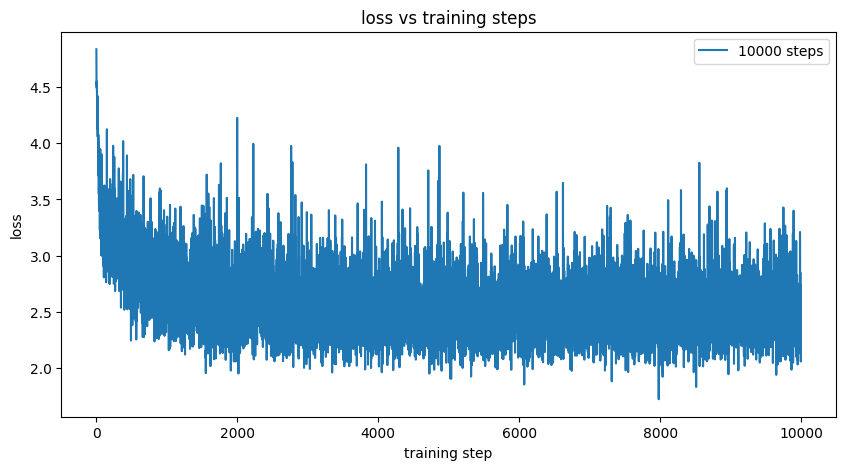

In [137]:
import matplotlib.pyplot as plt

# plot loss values
plt.figure(figsize=(10, 5))
plt.plot(loss_values, label=f"{train_steps} steps")
plt.xlabel('training step')
plt.ylabel('loss')
plt.title('loss vs training steps')
plt.legend()
plt.show()

## Predict

In [138]:
idx = torch.zeros([1, 1], dtype=torch.long)
print(decode(m.generate(idx, max_new_tokens=300)[0].tolist()))


IYB
YGY'[DWDB
GMSFIHNAYCA"YTD
TI
"HW[
"YY(IAYAASAYWTGILAO"WTW[SA:DMSRIBCWARLFASJSWDIT[IAGY
ATW[ITTGIHISMIIDCPAWFTFASWFdAYLAII(MT[YW[ATWA
AYW"Y
IMWTTIA
IPOA2[LIEAWIAT[TPWBAWYI"I[AYSiIYMW[BIBTTLHTA[[PYLITABSIWIL[NTIO"GSYTGBAYTRAWIS[[['[[RCMTBMIYIITIATRNTBTTIM’Y
FTIYA[IIMTIOBYT
HSITGY
BHB[W
IYIAHGIATYI


## Appendix

Model parameters

In [139]:
for param in m.parameters():
    print(f"{type(param)=} - {param=}: {param.size()=}")

type(param)=<class 'torch.nn.parameter.Parameter'> - param=Parameter containing:
tensor([[-0.3673,  0.2410, -1.5948,  ..., -1.1919,  0.2108,  0.3063],
        [ 0.1703, -0.6376,  0.0831,  ...,  1.7071, -0.2871,  1.3746],
        [-0.1138,  1.1233,  0.6161,  ..., -0.8544,  1.1236,  0.7157],
        ...,
        [ 0.4473,  0.7131, -0.2975,  ...,  0.0716,  0.8265,  0.2881],
        [ 0.6123,  0.0718,  1.5563,  ..., -0.1830, -0.9508, -0.4449],
        [-1.3940,  0.7285, -0.0385,  ..., -0.3494,  0.7610, -1.4065]],
       requires_grad=True): param.size()=torch.Size([104, 32])
type(param)=<class 'torch.nn.parameter.Parameter'> - param=Parameter containing:
tensor([[ 0.4469,  0.0686, -0.5936, -0.3778, -0.4723,  0.2290, -0.1857,  0.2374,
         -0.1527,  0.5924,  0.1400,  0.0943, -0.5390, -1.0642,  0.3637,  1.8483,
         -0.8170, -0.0585,  0.5910, -1.1764,  0.6504, -1.2327,  0.6541,  0.3159,
         -0.3246, -0.1503,  1.0383,  1.5434, -0.8378,  0.0761,  0.4234,  0.0726],
        [-0.6677

Expected loss (without training)

In [140]:
print(f"{-math.log(1/len(chars))}")

NameError: name 'math' is not defined